In [15]:
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdate

# Definindo os parâmetros de plotagem das figuras
plt.rcParams['figure.figsize'] = [10, 5]
plt.rcParams['figure.dpi'] = 300
plt.rcParams.update({'font.size': 10})

# Mostrar floats com duas casas decimas
pd.set_option('display.float_format',  lambda x: '%.4g' % x)
pd.options.display.max_colwidth = 20
pd.options.display.max_columns = 20
pd.options.display.max_rows = 6

In [16]:
# Load magic stocks prices
df_stocks = pd.read_csv(
    "../data/adjusted_prices.csv",
    parse_dates=['datneg', 'balancing_on', 'next_balancing'])
df_stocks

,datneg,codneg,nomres,preult,premed,balancing_on,next_balancing
0,2021-04-12,ALLD3,ALLIED,15.92,16.27,2021-04-12,2022-04-11
1,2021-04-13,ALLD3,ALLIED,15.85,15.96,2021-04-12,2022-04-11
2,2021-04-14,ALLD3,ALLIED,15.58,15.72,2021-04-12,2022-04-11
...,...,...,...,...,...,...,...
83189,2021-04-08,YDUQ3,YDUQS PART,30.28,29.8,2020-04-09,2021-04-12
83190,2021-04-09,YDUQ3,YDUQS PART,30.57,30.53,2020-04-09,2021-04-12
83191,2021-04-12,YDUQ3,YDUQS PART,30.58,30.59,2020-04-09,2021-04-12


In [17]:
# Create a column with the first price of the stock for each interval
df_stocks['first_value'] = df_stocks.groupby(
    by=['codneg', 'balancing_on'])['premed'].transform('first')
df_stocks

,datneg,codneg,nomres,preult,premed,balancing_on,next_balancing,first_value
0,2021-04-12,ALLD3,ALLIED,15.92,16.27,2021-04-12,2022-04-11,16.27
1,2021-04-13,ALLD3,ALLIED,15.85,15.96,2021-04-12,2022-04-11,16.27
2,2021-04-14,ALLD3,ALLIED,15.58,15.72,2021-04-12,2022-04-11,16.27
...,...,...,...,...,...,...,...,...
83189,2021-04-08,YDUQ3,YDUQS PART,30.28,29.8,2020-04-09,2021-04-12,26.16
83190,2021-04-09,YDUQ3,YDUQS PART,30.57,30.53,2020-04-09,2021-04-12,26.16
83191,2021-04-12,YDUQ3,YDUQS PART,30.58,30.59,2020-04-09,2021-04-12,26.16


In [18]:
# Normalize values with the first price of the stock for in each period
df_stocks['price_n'] = 100 * df_stocks['premed'] / df_stocks['first_value']
df_stocks

,datneg,codneg,nomres,preult,premed,balancing_on,next_balancing,first_value,price_n
0,2021-04-12,ALLD3,ALLIED,15.92,16.27,2021-04-12,2022-04-11,16.27,100
1,2021-04-13,ALLD3,ALLIED,15.85,15.96,2021-04-12,2022-04-11,16.27,98.12
2,2021-04-14,ALLD3,ALLIED,15.58,15.72,2021-04-12,2022-04-11,16.27,96.64
...,...,...,...,...,...,...,...,...,...
83189,2021-04-08,YDUQ3,YDUQS PART,30.28,29.8,2020-04-09,2021-04-12,26.16,113.9
83190,2021-04-09,YDUQ3,YDUQS PART,30.57,30.53,2020-04-09,2021-04-12,26.16,116.7
83191,2021-04-12,YDUQ3,YDUQS PART,30.58,30.59,2020-04-09,2021-04-12,26.16,116.9


In [19]:
# Create a new dataframe with portfolio prices -> daily mean price of the megic stocks
# of the period
df_portfolio = df_stocks.groupby(by=['datneg', 'next_balancing'])['price_n'].mean().reset_index()
df_portfolio.rename(columns={'price_n': 'price'}, inplace=True)
df_portfolio

,datneg,next_balancing,price
0,2011-04-11,2012-04-09,100
1,2011-04-12,2012-04-09,98.9
2,2011-04-13,2012-04-09,98.32
...,...,...,...
2797,2022-07-13,2023-04-11,84.67
2798,2022-07-14,2023-04-11,82.73
2799,2022-07-15,2023-04-11,83.12


In [20]:
# Create a column for storing the last portfolio price of the period
df_portfolio['last_price'] = df_portfolio.groupby(by=['next_balancing'])['price'].transform('last')
df_portfolio

,datneg,next_balancing,price,last_price
0,2011-04-11,2012-04-09,100,107.9
1,2011-04-12,2012-04-09,98.9,107.9
2,2011-04-13,2012-04-09,98.32,107.9
...,...,...,...,...
2797,2022-07-13,2023-04-11,84.67,83.12
2798,2022-07-14,2023-04-11,82.73,83.12
2799,2022-07-15,2023-04-11,83.12,83.12


In [21]:
# The multiplier column will store the last price only in the last day of the group,
# making others values equal to 1
df_portfolio['multiplier'] = np.where(
    df_portfolio['datneg'] == df_portfolio['next_balancing'],
    df_portfolio['last_price'] / 100,
    1
)
df_portfolio

,datneg,next_balancing,price,last_price,multiplier
0,2011-04-11,2012-04-09,100,107.9,1
1,2011-04-12,2012-04-09,98.9,107.9,1
2,2011-04-13,2012-04-09,98.32,107.9,1
...,...,...,...,...,...
2797,2022-07-13,2023-04-11,84.67,83.12,1
2798,2022-07-14,2023-04-11,82.73,83.12,1
2799,2022-07-15,2023-04-11,83.12,83.12,1


In [22]:
# Calculate the product in the multiplier column and store it in 
# 'acumm_adjustment' column
df_portfolio['accum_adjustment'] = df_portfolio['multiplier'].cumprod() 
# Check values in first annual portfolio transition
df_portfolio[246:251]

,datneg,next_balancing,price,last_price,multiplier,accum_adjustment
246,2012-04-04,2012-04-09,108.6,107.9,1,1
247,2012-04-05,2012-04-09,109.5,107.9,1,1
248,2012-04-09,2012-04-09,107.9,107.9,1.079,1.079
249,2012-04-09,2013-04-10,100,116.9,1,1.079
250,2012-04-10,2013-04-10,98.96,116.9,1,1.079


In [23]:
df_portfolio['accum_price'] = df_portfolio['price'] * df_portfolio['accum_adjustment']
# Check values in first annual portfolio transition
df_portfolio[246:251]

,datneg,next_balancing,price,last_price,multiplier,accum_adjustment,accum_price
246,2012-04-04,2012-04-09,108.6,107.9,1,1,108.6
247,2012-04-05,2012-04-09,109.5,107.9,1,1,109.5
248,2012-04-09,2012-04-09,107.9,107.9,1.079,1.079,116.5
249,2012-04-09,2013-04-10,100,116.9,1,1.079,107.9
250,2012-04-10,2013-04-10,98.96,116.9,1,1.079,106.8


In [24]:
# In porfolio transitions days, there will be two rows with equal trade day ('datneg')
# and two cutoff days. The second row holds already the portfolio gain from previuos
# period since is being multiplied by 'accum_adjustment' column.
# Therefore, only the second row should be kept.
df_portfolio.drop_duplicates('datneg', keep='last', inplace=True, ignore_index=True)
df_portfolio[247:250]

,datneg,next_balancing,price,last_price,multiplier,accum_adjustment,accum_price
247,2012-04-05,2012-04-09,109.5,107.9,1,1,109.5
248,2012-04-09,2013-04-10,100,116.9,1,1.079,107.9
249,2012-04-10,2013-04-10,98.96,116.9,1,1.079,106.8


In [25]:
# Load IBOV series
# s3://aq-dl/HistoricalQuotations/base_adj.feather
file_path = "/mnt/aq_disk/data/HistoricalQuotations/processed/dataset.feather"
df_ibov = (pd
    .read_feather(file_path)
    .query('codneg == "IBOV" and datneg >= "2011-04-11"')
    [['datneg', 'premed']]
)
df_ibov.reset_index(drop=True, inplace=True)
df_ibov

,datneg,premed
0,2011-04-11,6.852e+04
1,2011-04-12,6.748e+04
2,2011-04-13,6.676e+04
...,...,...
2784,2022-07-13,9.812e+04
2785,2022-07-14,9.683e+04
2786,2022-07-15,9.623e+04


In [26]:
# Normalize values with the first price of the stock for in each period
df_ibov.premed = 100 * df_ibov.premed / df_ibov.loc[0, 'premed']
df_ibov

,datneg,premed
0,2011-04-11,100
1,2011-04-12,98.48
2,2011-04-13,97.43
...,...,...
2784,2022-07-13,143.2
2785,2022-07-14,141.3
2786,2022-07-15,140.4


In [27]:
# Merge the two dataframes and change price names for plotting
df_portfolio = df_portfolio.merge(right=df_ibov, how='inner')
df_portfolio.rename(
    columns={"accum_price": "MagicFormula", "premed": "Ibovespa"}, inplace=True)
df_portfolio.set_index('datneg', inplace=True)
# Remove columns with intermediate calculations.
df_portfolio.drop(
    columns=['price', 'last_price', 'multiplier', 'accum_adjustment'], inplace=True)
df_portfolio

,next_balancing,MagicFormula,Ibovespa
datneg,,,
2011-04-11,2012-04-09,100,100
2011-04-12,2012-04-09,98.9,98.48
2011-04-13,2012-04-09,98.32,97.43
...,...,...,...
2022-07-13,2023-04-11,269,143.2
2022-07-14,2023-04-11,262.8,141.3
2022-07-15,2023-04-11,264.1,140.4


In [28]:
df_portfolio.tail(10)

,next_balancing,MagicFormula,Ibovespa
datneg,,,
2022-07-04,2023-04-11,268.8,144.2
2022-07-05,2023-04-11,263.7,143
2022-07-06,2023-04-11,267.9,143.6
...,...,...,...
2022-07-13,2023-04-11,269,143.2
2022-07-14,2023-04-11,262.8,141.3
2022-07-15,2023-04-11,264.1,140.4


<AxesSubplot:xlabel='datneg'>

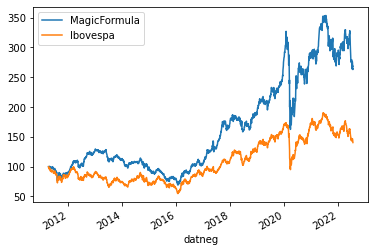

In [29]:
# Simple plot
df_portfolio[['MagicFormula', 'Ibovespa']].plot()

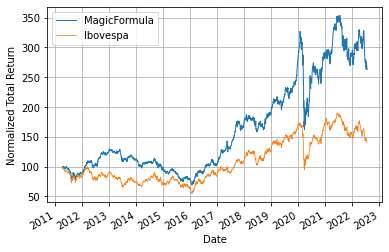

In [31]:
# Adjusted plot
df_portfolio['MagicFormula'].plot(linestyle='-', linewidth = 1, label='MagicFormula')
df_portfolio['Ibovespa'].plot(linestyle='-', linewidth = .75, label='Ibovespa')
# plt.title('Portfolio Total Return applying Magic Formula Strategy in the Brazilian market')
plt.ylabel('Normalized Total Return')
plt.yticks(np.arange(50, 400, step=50))
plt.xlabel('Date')
# plt.yscale('log')
plt.legend(loc='upper left')
plt.grid(True)
locator = mdate.YearLocator()
plt.gca().xaxis.set_major_locator(locator)
plt.gcf().autofmt_xdate()
plt.savefig('../images/magic_ibov.jpg', dpi=300, transparent=False)